# Inference Example for Cotatron

This script shows the example usage of pre-trained Cotatron and
voice conversion system trained with them.

In [1]:
#!pip install omegaconf unidecode pytorch-lightning==0.7.1 pyyaml

## Import requirements

In [1]:
import os
import gdown
import librosa
import argparse
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from matplotlib.colors import Normalize

import torch
import torch.nn as nn
import torch.nn.functional as F


os.sys.path.append("../")
from synthesizer import Synthesizer
from datasets.text import Language

## Download pre-trained weights and config files

The pre-trained decoder file also contains the cotatron by itself.

In [2]:
hp_path = ['../config/global/default.yaml', '../config/vc/default.yaml']

hp_global = OmegaConf.load(hp_path[0])
hp_vc = OmegaConf.load(hp_path[1])
hp = OmegaConf.merge(hp_global, hp_vc)

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--config')
hparams = parser.parse_args(['--config', hp_path])

In [21]:
checkpoint = torch.load('../chkpt/vc/cotatron_trained_vc/b7d9845epoch=9.ckpt', map_location='cpu')

model = Synthesizer(hparams)#.cuda()
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model.freeze()

In [6]:
lang = Language(hp.data.lang, hp.data.text_cleaners)

## Prepare the source speech and its transcription

In [11]:
import random

with open('../datasets/metadata/estonian_metadata.txt', 'r') as f:
    sentences = f.readlines()
    
random_input = random.choice(sentences)
random_input

'preprocessed_v2/UT-uudised-Mari/Mari/wavs/0001_art_901_lause_18-22k.wav|Kurb öelda, aga Eestis on haiglaid, kus ei tööta psühhiaatreid.|UT-uudised-Mari\n'

In [17]:
text = random_input.split('|')[1]
source_wavpath = '../data/' + random_input.split('|')[0]

In [27]:
text_norm = torch.LongTensor(lang.text_to_sequence(text, hp.data.text_cleaners))
text_norm = text_norm.unsqueeze(0)#.cuda()

wav_source_original, sr = librosa.load(source_wavpath, sr=None, mono=True)
wav_source_original *= (0.99 / np.max(np.abs(wav_source_original)))
assert sr == hp.audio.sampling_rate
wav_source = torch.from_numpy(wav_source_original).view(1, 1, -1)#.cuda()
mel_source = model.cotatron.audio2mel(wav_source)

target_speaker = torch.LongTensor([hp.data.speakers.index('ERR-uudised-Tonu_Karjatse')])#.cuda()

## Convert (Inference)

In [28]:
with torch.no_grad():
    mel_s_t, alignment, residual = model.inference(text_norm, mel_source, target_speaker)

In [29]:
ms = mel_source[0].cpu().detach().numpy()
mst = mel_s_t[0].cpu().detach().numpy()
a = alignment[0].cpu().detach().numpy()
r = residual[0][0].cpu().detach().numpy()

In [30]:
%matplotlib inline
def show_spectrogram(mel):
    plt.figure(figsize=(15, 4))
    plt.imshow(mel, aspect='auto', origin='lower', interpolation='none')
    plt.xlabel('time frames')
    plt.ylabel('mel')
    plt.subplots_adjust(bottom=0.1, right=0.88, top=0.9)
    cax = plt.axes([0.9, 0.1, 0.02, 0.8])
    plt.colorbar(cax=cax)
    plt.show()

## Alignment plot
Note that the Cotatron learns text-audio alignment in totally unsupervised manner.

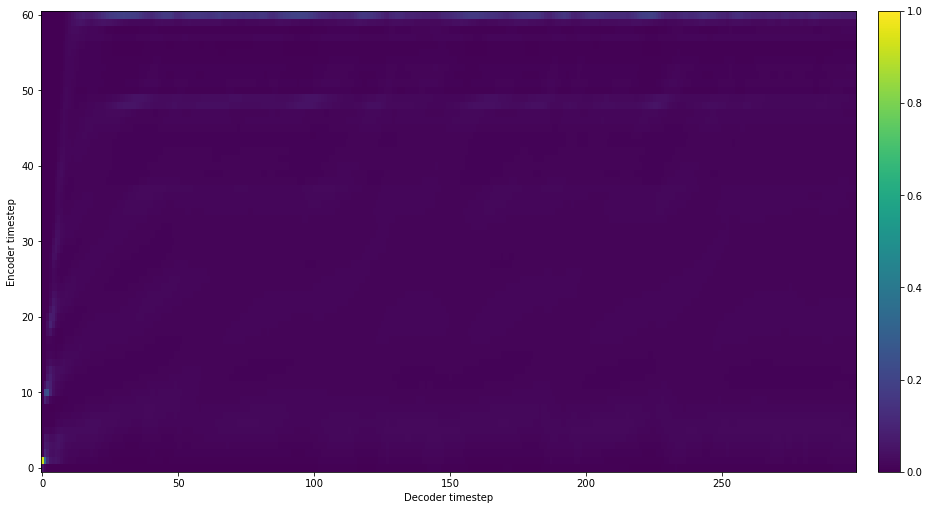

In [31]:
%matplotlib inline
plt.figure(figsize=(15, 8))
plt.imshow(a.T, aspect='auto', origin='lower', interpolation='none', norm=Normalize(vmin=0.0, vmax=1.0))
plt.xlabel('Decoder timestep')
plt.ylabel('Encoder timestep')
plt.subplots_adjust(bottom=0.1, right=0.88, top=0.9)
cax = plt.axes([0.9, 0.1, 0.02, 0.8])
plt.colorbar(cax=cax)
plt.show()

## Source mel-spectrogram

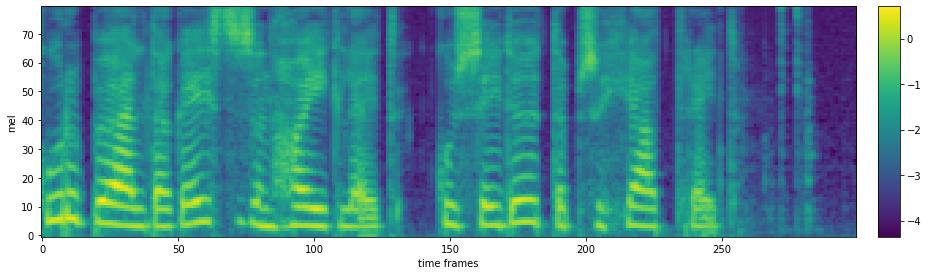

In [32]:
show_spectrogram(ms)

## Converted mel-spectrogram

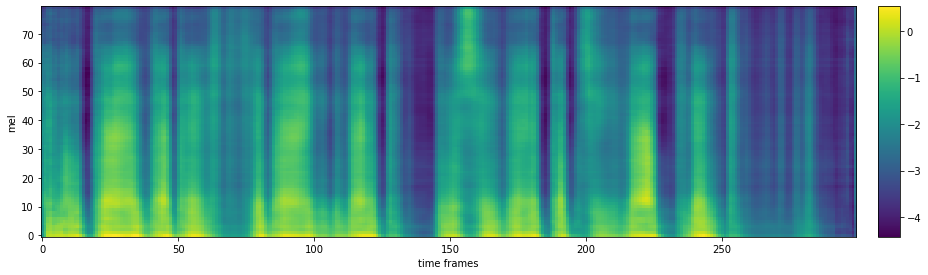

In [33]:
show_spectrogram(mst)

## Visualization of residual features

average residual value: -0.019


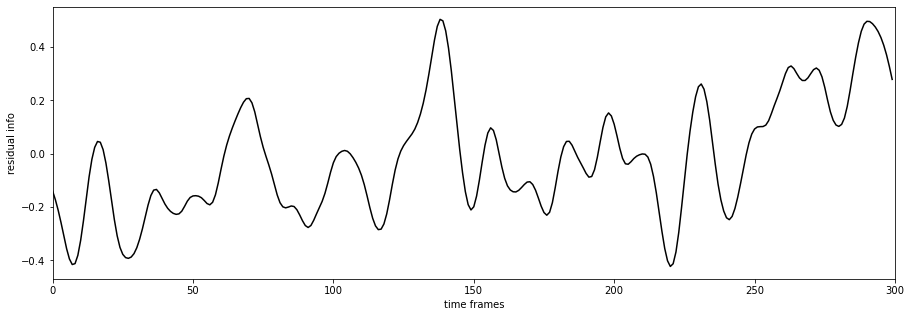

In [34]:
%matplotlib inline
plt.figure(figsize=(15, 5))
plt.plot(r, color='black')
plt.xlim(0, len(r))
# plt.ylim(-1, 1)
plt.xlabel('time frames')
plt.ylabel('residual info')
plt.subplots_adjust(left=0.1, right=0.88)
print('average residual value: %.3f' % (sum(r) / len(r)))

## Convert mel-spectrogram into raw-audio with MelGAN

As described in our paper, the melgan is pre-trained with whole LibriTTS dataset.

In [35]:
from melgan.generator import Generator

In [37]:
gdown.download('https://drive.google.com/uc?id=1sYSFFxL0JFUzP1TdhjuFfOEPByQGryxt', 'melgan_libritts_g_only.ckpt', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1sYSFFxL0JFUzP1TdhjuFfOEPByQGryxt
To: /gpfs/space/home/zuppur/cotatron/jupiter/melgan_libritts_g_only.ckpt
17.1MB [00:00, 30.4MB/s]


'melgan_libritts_g_only.ckpt'

In [38]:
melgan = Generator(80)#.cuda()
melgan_ckpt = torch.load('melgan_libritts_g_only.ckpt', map_location='cpu')
melgan.load_state_dict(melgan_ckpt['model_g'])
melgan.eval()

In [39]:
with torch.no_grad():
    audio_s_t = melgan(mel_s_t).squeeze().cpu().detach().numpy()

## Finally, the audio samples!

### Source speech

In [40]:
ipd.Audio(wav_source_original, rate=22050)

### Converted speech
Synthesized with Cotatron-based VC system + MelGAN.

In [41]:
ipd.Audio(audio_s_t, rate=22050)

## Caveat

The checkpoint that we release via this Jupyter Notebook is different from the one we used for writing our paper. For instance, the decoder was trained for only 7 days with single GPU for now.

Therefore, the results produced with this notebook might differ from the results shown in our paper or the audio samples webpage.